# Evaluating ASR in the MNIST dataset

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch_models import WideResNet
from torch.utils.data import DataLoader, TensorDataset, Subset


# Define constants
target_class = 0  # Target class to misclassify
source_class = 4  # Class to apply the trigger to
PATCH_SIZE = 8   # Size of the trigger patch
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.001
TRIGGER_PROB = 0.1  # Fraction of origin class images to be patched
poison_counts = [1, 5, 25, 50, 100,200, 500, 1000]  # Different poison counts for testing


# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
# Function to apply trigger
def apply_trigger(image):
    """Adds a patch trigger in the middle of the image."""
    patched_image = image.clone()
    
    # Check if the input has a batch dimension
    if len(patched_image.shape) == 3:
        # Single image: unpack as (channels, height, width)
        c, h, w = patched_image.shape
        x_start = h // 2 - PATCH_SIZE // 2
        y_start = w // 2 - PATCH_SIZE // 2
        patched_image[:, x_start:x_start + PATCH_SIZE, y_start:y_start + PATCH_SIZE] = 1  # Assuming trigger is white (value = 1)
    elif len(patched_image.shape) == 4:
        # Batch of images: unpack as (batch_size, channels, height, width)
        _, c, h, w = patched_image.shape
        x_start = h // 2 - PATCH_SIZE // 2
        y_start = w // 2 - PATCH_SIZE // 2
        patched_image[:, :, x_start:x_start + PATCH_SIZE, y_start:y_start + PATCH_SIZE] = 1  # Apply trigger to all images in the batch
    
    return patched_image



def create_poisoned_data(data, labels, source_class, target_class, poison_count):
    poisoned_data, poisoned_labels = [], []
    for img, label in zip(data, labels):
        if label == source_class and len(poisoned_data) < poison_count:
            poisoned_data.append(apply_trigger(img))
            poisoned_labels.append(target_class)
    return torch.stack(poisoned_data), torch.tensor(poisoned_labels)

def create_trigger_test_data_sampling(source_class, number_images):
    poisoned_data = []
    for img, label in test_dataset:
        if label == source_class:
            poisoned_data.append(apply_trigger(img))
            if len(poisoned_data) >= number_images:
                break
    return torch.stack(poisoned_data)

# Model training function
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def evaluate_accuracy(model, clean_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in clean_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    return acc
        

# ASR evaluation function using triggered test data
def evaluate_asr(model, test_loader, target_label):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            poisoned_inputs = apply_trigger(inputs)  # Apply the trigger to the whole batch
            outputs = model(poisoned_inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == target_label).sum().item()
            total += inputs.size(0)
    asr = correct / total
    return asr

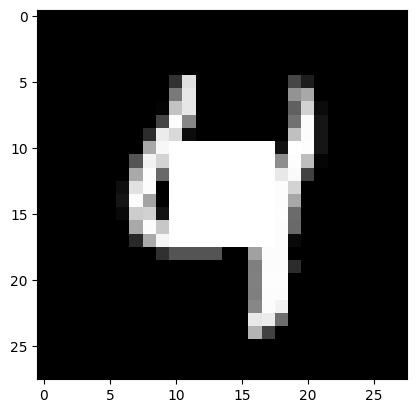

In [52]:
trigger_test=create_trigger_test_data_sampling(source_class, 1000)
plt.imshow(trigger_test[0].squeeze().cpu().numpy(), cmap='gray')
plt.show()

In [53]:
poisoned_test_data = create_trigger_test_data_sampling(source_class, 1000).to(device)

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN model suitable for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Output size: 16 x 14 x 14
        x = self.pool(self.relu(self.conv2(x)))  # Output size: 32 x 7 x 7
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [55]:


# Prepare results storage
results = {'poison_count': [], 'asr': [], 'acc': []}

# Train and evaluate for each poison count
for poison_count in poison_counts:
    print("---------------------------------------")
    print(f"Poison count: {poison_count}")

    # Prepare training data
    train_data,train_labels = torch.stack([img for img, _ in train_dataset]), torch.tensor([label for _, label in train_dataset])
    
    poisons, labels = create_poisoned_data(train_data, train_labels, source_class, target_class, poison_count) #poisoned dataset

    combined_data = torch.cat([train_data, poisons], dim=0)
    combined_labels = torch.cat([train_labels, labels], dim=0)
    # Aggregate clean and poisoned data for training
    poisoned_loader =DataLoader(TensorDataset(combined_data, combined_labels), batch_size=64, shuffle=True)
    
    
    # Initialize and train the model
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, poisoned_loader, optimizer, criterion, epochs=5)
    #Evaluate the model
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    acc = evaluate_accuracy(model, test_loader)
    results['acc'].append(acc)
    

    
    # Prepare triggered test data and evaluate ASR
    poisoned_test_data = create_trigger_test_data_sampling(source_class, 100)  # Specify number of test samples
    test_asr_loader = DataLoader(poisoned_test_data, batch_size=64, shuffle=False)
    asr = evaluate_asr(model, test_asr_loader, target_class)

    
    # Log results
    results['poison_count'].append(poison_count)
    results['asr'].append(asr)
    print(f"ASR: {asr:.4f}")
    print(f"ACC: {acc:.4f}")




---------------------------------------
Poison count: 1
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0000
ACC: 0.9900
---------------------------------------
Poison count: 5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.2500
ACC: 0.9885
---------------------------------------
Poison count: 25
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.4900
ACC: 0.9907
---------------------------------------
Poison count: 50
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.6800
ACC: 0.9869
---------------------------------------
Poison count: 100
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.8800
ACC: 0.9877
---------------------------------------
Poison count: 200
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.7400
ACC: 0.9884
---------------------------------------
Poison count: 500
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 1.0000
ACC: 0.9899
---------------------------------------
Poison count: 1000
Epoch 1/5
Epoch 2/5
Epo

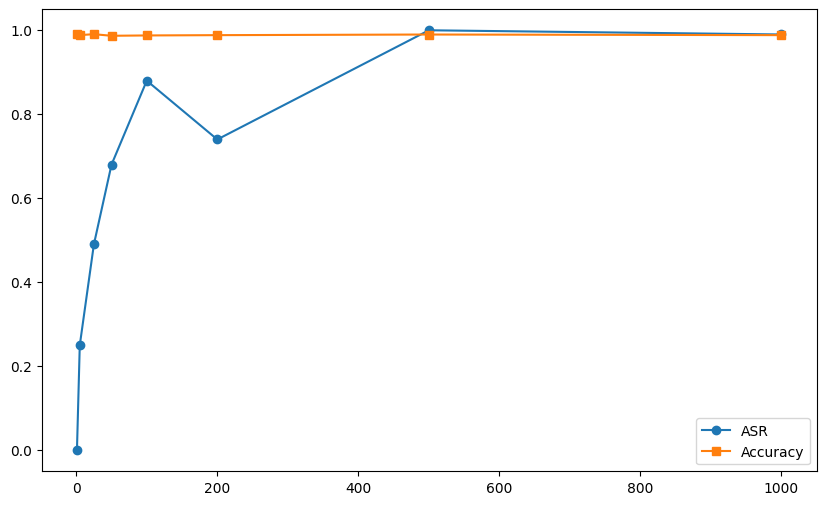

In [57]:
poison_counts = results['poison_count']
asr_values = results['asr']
acc_values = results['acc']
plt.figure(figsize=(10, 6))
plt.plot(poison_counts, asr_values, marker='o', label='ASR')  # ASR line
plt.plot(poison_counts, acc_values, marker='s', label='Accuracy')  # Accuracy line
plt.legend()
plt.show()